In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [35]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [11]:
train_dir = 'data/512/train/'
test_dir = 'data/512/test/'
test_dir_whithout_aug = "data/512/test-without-aug/"

extracted_features_dir = "extracted_features/"
model_name = "DenseNetModified"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [29]:
output_classes = 4
batch_size = 2
img_height, img_width = 512, 384
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_dir)])
nb_test_without_aug_samples = sum([len(files) for r, d, files in os.walk(test_dir_whithout_aug)])

print("train samples:", nb_train_samples)
print("test samples:", nb_test_samples)
print("test without aug samples:", nb_test_without_aug_samples)

top_model_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_weights.h5')

train samples: 4608
test samples: 1792
test without aug samples: 112


In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir_whithout_aug):
    print (root, len(files))

data/512/train/ 0
data/512/train/Benign 1152
data/512/train/InSitu 1152
data/512/train/Invasive 1152
data/512/train/Normal 1152
******************************
data/512/test/ 0
data/512/test/Benign 448
data/512/test/InSitu 448
data/512/test/Invasive 448
data/512/test/Normal 448
******************************
data/512/test-without-aug/ 0
data/512/test-without-aug/Benign 28
data/512/test-without-aug/InSitu 28
data/512/test-without-aug/Invasive 28
data/512/test-without-aug/Normal 28


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

test_generator_without_aug = test_datagen.flow_from_directory(
    test_dir_whithout_aug,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3456 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 1792 images belonging to 4 classes.
Found 112 images belonging to 4 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3456
nb_validation_samples: 1152

predict_size_train: 1728
predict_size_validation: 576
nb_test_without_aug_samples: 112
predict_size_test_without_aug_samples: 56
nb_test_samples: 1792
predict_size_test: 896

 num_classes: 4


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
# -*- coding: utf-8 -*-
'''DenseNet and DenseNet-FCN models for Keras.

DenseNet is a network architecture where each layer is directly connected
to every other layer in a feed-forward fashion (within each dense block).
For each layer, the feature maps of all preceding layers are treated as
separate inputs whereas its own feature maps are passed on as inputs to
all subsequent layers. This connectivity pattern yields state-of-the-art
accuracies on CIFAR10/100 (with or without data augmentation) and SVHN.
On the large scale ILSVRC 2012 (ImageNet) dataset, DenseNet achieves a
similar accuracy as ResNet, but using less than half the amount of
parameters and roughly half the number of FLOPs.

DenseNets support any input image size of 32x32 or greater, and are thus
suited for CIFAR-10 or CIFAR-100 datasets. There are two types of DenseNets,
one suited for smaller images (DenseNet) and one suited for ImageNet,
called DenseNetImageNet. They are differentiated by the strided convolution
and pooling operations prior to the initial dense block.

The following table describes the size and accuracy of DenseNetImageNet models
on the ImageNet dataset (single crop), for which weights are provided:
------------------------------------------------------------------------------------
    Model type      | ImageNet Acc (Top 1)  |  ImageNet Acc (Top 5) |  Params (M)  |
------------------------------------------------------------------------------------
|   DenseNet-121    |    25.02 %            |        7.71 %         |     8.0      |
|   DenseNet-169    |    23.80 %            |        6.85 %         |     14.3     |
|   DenseNet-201    |    22.58 %            |        6.34 %         |     20.2     |
|   DenseNet-161    |    22.20 %            |         -   %         |     28.9     |
------------------------------------------------------------------------------------

DenseNets can be extended to image segmentation tasks as described in the
paper "The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for
Semantic Segmentation". Here, the dense blocks are arranged and concatenated
with long skip connections for state of the art performance on the CamVid dataset.

# Reference
- [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf)
- [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic
   Segmentation](https://arxiv.org/pdf/1611.09326.pdf)

This implementation is based on the following reference code:
 - https://github.com/gpleiss/efficient_densenet_pytorch
 - https://github.com/liuzhuang13/DenseNet

'''
# -*- coding: utf-8 -*-
# from __future__ import absolute_import

from keras.layers import Layer

from keras import backend as KC
# from keras.utils.conv_utils import normalize_data_format

import keras.backend as K


def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.

    Copy of the function of keras-team/keras because it's not in the public API
    So we can't use the function in keras-team/keras to test tf.keras

    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.

    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride


def normalize_data_format(value):
    """Checks that the value correspond to a valid data format.

    Copy of the function in keras-team/keras because it's not public API.

    # Arguments
        value: String or None. `'channels_first'` or `'channels_last'`.

    # Returns
        A string, either `'channels_first'` or `'channels_last'`

    # Example
    ```python
        >>> from keras import backend as K
        >>> K.normalize_data_format(None)
        'channels_first'
        >>> K.normalize_data_format('channels_last')
        'channels_last'
    ```

    # Raises
        ValueError: if `value` or the global `data_format` invalid.
    """
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format

class SubPixelUpscaling(Layer):
    """ Sub-pixel convolutional upscaling layer.

    This layer requires a Convolution2D prior to it,
    having output filters computed according to
    the formula :

        filters = k * (scale_factor * scale_factor)
        where k = a user defined number of filters (generally larger than 32)
              scale_factor = the upscaling factor (generally 2)

    This layer performs the depth to space operation on
    the convolution filters, and returns a
    tensor with the size as defined below.

    # Example :
    ```python
        # A standard subpixel upscaling block
        x = Convolution2D(256, 3, 3, padding='same', activation='relu')(...)
        u = SubPixelUpscaling(scale_factor=2)(x)

        # Optional
        x = Convolution2D(256, 3, 3, padding='same', activation='relu')(u)
    ```

    In practice, it is useful to have a second convolution layer after the
    SubPixelUpscaling layer to speed up the learning process.

    However, if you are stacking multiple
    SubPixelUpscaling blocks, it may increase
    the number of parameters greatly, so the
    Convolution layer after SubPixelUpscaling
    layer can be removed.

    # Arguments
        scale_factor: Upscaling factor.
        data_format: Can be None, 'channels_first' or 'channels_last'.

    # Input shape
        4D tensor with shape:
        `(samples, k * (scale_factor * scale_factor) channels, rows, cols)`
        if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, k * (scale_factor * scale_factor) channels)`
        if data_format='channels_last'.

    # Output shape
        4D tensor with shape:
        `(samples, k channels, rows * scale_factor, cols * scale_factor))`
        if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows * scale_factor, cols * scale_factor, k channels)`
        if data_format='channels_last'.

    # References
        - [Real-Time Single Image and Video Super-Resolution Using an
           Efficient Sub-Pixel Convolutional Neural Network](
           https://arxiv.org/abs/1609.05158)
    """

    def __init__(self, scale_factor=2, data_format=None, **kwargs):
        super(SubPixelUpscaling, self).__init__(**kwargs)

        self.scale_factor = scale_factor
        self.data_format = normalize_data_format(data_format)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        y = KC.depth_to_space(x, self.scale_factor, self.data_format)
        return y

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            b, k, r, c = input_shape
            new_k = k // (self.scale_factor ** 2)
            new_r = r * self.scale_factor
            new_c = c * self.scale_factor
            return b, new_k, new_r, new_c
        else:
            b, r, c, k = input_shape
            new_r = r * self.scale_factor
            new_c = c * self.scale_factor
            new_k = k // (self.scale_factor ** 2)
            return b, new_r, new_c, new_k

    def get_config(self):
        config = {'scale_factor': self.scale_factor,
                  'data_format': self.data_format}
        base_config = super(SubPixelUpscaling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# from __future__ import print_function
# from __future__ import absolute_import
# from __future__ import division

import warnings

from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.imagenet_utils import preprocess_input as _preprocess_input
import keras.backend as K

# from keras_contrib.layers import SubPixelUpscaling
# -*- coding: utf-8 -*-
# from __future__ import absolute_import

from keras.layers import Layer

# from keras_contrib import backend as KC
# from keras_contrib.utils.conv_utils import normalize_data_format


class SubPixelUpscaling(Layer):
    """ Sub-pixel convolutional upscaling layer.

    This layer requires a Convolution2D prior to it,
    having output filters computed according to
    the formula :

        filters = k * (scale_factor * scale_factor)
        where k = a user defined number of filters (generally larger than 32)
              scale_factor = the upscaling factor (generally 2)

    This layer performs the depth to space operation on
    the convolution filters, and returns a
    tensor with the size as defined below.

    # Example :
    ```python
        # A standard subpixel upscaling block
        x = Convolution2D(256, 3, 3, padding='same', activation='relu')(...)
        u = SubPixelUpscaling(scale_factor=2)(x)

        # Optional
        x = Convolution2D(256, 3, 3, padding='same', activation='relu')(u)
    ```

    In practice, it is useful to have a second convolution layer after the
    SubPixelUpscaling layer to speed up the learning process.

    However, if you are stacking multiple
    SubPixelUpscaling blocks, it may increase
    the number of parameters greatly, so the
    Convolution layer after SubPixelUpscaling
    layer can be removed.

    # Arguments
        scale_factor: Upscaling factor.
        data_format: Can be None, 'channels_first' or 'channels_last'.

    # Input shape
        4D tensor with shape:
        `(samples, k * (scale_factor * scale_factor) channels, rows, cols)`
        if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, k * (scale_factor * scale_factor) channels)`
        if data_format='channels_last'.

    # Output shape
        4D tensor with shape:
        `(samples, k channels, rows * scale_factor, cols * scale_factor))`
        if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows * scale_factor, cols * scale_factor, k channels)`
        if data_format='channels_last'.

    # References
        - [Real-Time Single Image and Video Super-Resolution Using an
           Efficient Sub-Pixel Convolutional Neural Network](
           https://arxiv.org/abs/1609.05158)
    """

    def __init__(self, scale_factor=2, data_format=None, **kwargs):
        super(SubPixelUpscaling, self).__init__(**kwargs)

        self.scale_factor = scale_factor
        self.data_format = normalize_data_format(data_format)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        y = KC.depth_to_space(x, self.scale_factor, self.data_format)
        return y

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            b, k, r, c = input_shape
            new_k = k // (self.scale_factor ** 2)
            new_r = r * self.scale_factor
            new_c = c * self.scale_factor
            return b, new_k, new_r, new_c
        else:
            b, r, c, k = input_shape
            new_r = r * self.scale_factor
            new_c = c * self.scale_factor
            new_k = k // (self.scale_factor ** 2)
            return b, new_r, new_c, new_k

    def get_config(self):
        config = {'scale_factor': self.scale_factor,
                  'data_format': self.data_format}
        base_config = super(SubPixelUpscaling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    
DENSENET_121_WEIGHTS_PATH = (r'https://github.com/titu1994/DenseNet/releases/download'
                             r'/v3.0/DenseNet-BC-121-32.h5')
DENSENET_161_WEIGHTS_PATH = (r'https://github.com/titu1994/DenseNet/releases/download'
                             r'/v3.0/DenseNet-BC-161-48.h5')
DENSENET_169_WEIGHTS_PATH = (r'https://github.com/titu1994/DenseNet/releases/download'
                             r'/v3.0/DenseNet-BC-169-32.h5')
DENSENET_121_WEIGHTS_PATH_NO_TOP = (r'https://github.com/titu1994/DenseNet/releases/'
                                    r'download/v3.0/DenseNet-BC-121-32-no-top.h5')
DENSENET_161_WEIGHTS_PATH_NO_TOP = (r'https://github.com/titu1994/DenseNet/releases/'
                                    r'download/v3.0/DenseNet-BC-161-48-no-top.h5')
DENSENET_169_WEIGHTS_PATH_NO_TOP = (r'https://github.com/titu1994/DenseNet/releases/'
                                    r'download/v3.0/DenseNet-BC-169-32-no-top.h5')


def preprocess_input(x, data_format=None):
    """Preprocesses a tensor encoding a batch of images.

    # Arguments
        x: input Numpy tensor, 4D.
        data_format: data format of the image tensor.

    # Returns
        Preprocessed tensor.
    """
    x = _preprocess_input(x, data_format=data_format)
    x *= 0.017  # scale values
    return x


def DenseNet(input_shape=None,
             depth=40,
             nb_dense_block=3,
             growth_rate=12,
             nb_filter=-1,
             nb_layers_per_block=-1,
             bottleneck=False,
             reduction=0.0,
             dropout_rate=0.0,
             weight_decay=1e-4,
             subsample_initial_block=False,
             include_top=True,
             weights=None,
             input_tensor=None,
             pooling=None,
             classes=10,
             activation='softmax',
             transition_pooling='avg'):
    '''Instantiate the DenseNet architecture.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        depth: number or layers in the DenseNet
        nb_dense_block: number of dense blocks to add to end
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters. -1 indicates initial
            number of filters will default to 2 * growth_rate
        nb_layers_per_block: number of layers in each dense block.
            Can be a -1, positive integer or a list.
            If -1, calculates nb_layer_per_block from the network depth.
            If positive integer, a set number of layers per dense block.
            If list, nb_layer is used as provided. Note that list size must
            be nb_dense_block
        bottleneck: flag to add bottleneck blocks in between dense blocks
        reduction: reduction factor of transition blocks.
            Note : reduction value is inverted to compute compression.
        dropout_rate: dropout rate
        weight_decay: weight decay rate
        subsample_initial_block: Changes model type to suit different datasets.
            Should be set to True for ImageNet, and False for CIFAR datasets.
            When set to True, the initial convolution will be strided and
            adds a MaxPooling2D before the initial dense block.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization) or
            'imagenet' (pre-training on ImageNet)..
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
        activation: Type of activation at the top layer. Can be one of
            'softmax' or 'sigmoid'. Note that if sigmoid is used,
             classes must be 1.
        transition_pooling: `avg` for avg pooling (default), `max` for max pooling,
            None for no pooling during scale transition blocks. Please note that this
            default differs from the DenseNetFCN paper in accordance with the DenseNet
            paper.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    '''

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as ImageNet with `include_top` '
                         'as true, `classes` should be 1000')

    if activation not in ['softmax', 'sigmoid']:
        raise ValueError('activation must be one of "softmax" or "sigmoid"')

    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_dense_net(classes, img_input, include_top, depth, nb_dense_block,
                           growth_rate, nb_filter, nb_layers_per_block, bottleneck,
                           reduction, dropout_rate, weight_decay,
                           subsample_initial_block, pooling, activation,
                           transition_pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='densenet')

    # load weights
    if weights == 'imagenet':
        weights_loaded = False

        if ((depth == 121) and (nb_dense_block == 4) and (growth_rate == 32) and
                (nb_filter == 64) and (bottleneck is True) and (reduction == 0.5) and
                subsample_initial_block):
            if include_top:
                weights_path = get_file('DenseNet-BC-121-32.h5',
                                        DENSENET_121_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='a439dd41aa672aef6daba4ee1fd54abd')
            else:
                weights_path = get_file('DenseNet-BC-121-32-no-top.h5',
                                        DENSENET_121_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='55e62a6358af8a0af0eedf399b5aea99')
            model.load_weights(weights_path, by_name=True)
            weights_loaded = True

        if ((depth == 161) and (nb_dense_block == 4) and (growth_rate == 48) and
                (nb_filter == 96) and (bottleneck is True) and (reduction == 0.5) and
                subsample_initial_block):
            if include_top:
                weights_path = get_file('DenseNet-BC-161-48.h5',
                                        DENSENET_161_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='6c326cf4fbdb57d31eff04333a23fcca')
            else:
                weights_path = get_file('DenseNet-BC-161-48-no-top.h5',
                                        DENSENET_161_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='1a9476b79f6b7673acaa2769e6427b92')
            model.load_weights(weights_path, by_name=True)
            weights_loaded = True

        if ((depth == 169) and (nb_dense_block == 4) and (growth_rate == 32) and
                (nb_filter == 64) and (bottleneck is True) and (reduction == 0.5) and
                subsample_initial_block):
            if include_top:
                weights_path = get_file('DenseNet-BC-169-32.h5',
                                        DENSENET_169_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='914869c361303d2e39dec640b4e606a6')
            else:
                weights_path = get_file('DenseNet-BC-169-32-no-top.h5',
                                        DENSENET_169_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='89c19e8276cfd10585d5fadc1df6859e')
            model.load_weights(weights_path, by_name=True)
            weights_loaded = True

        if weights_loaded:
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)

            if ((K.image_data_format() == 'channels_first') and
                    (K.backend() == 'tensorflow')):
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')

            print("Weights for the model were loaded successfully")

    return model


def DenseNetFCN(input_shape, nb_dense_block=5, growth_rate=16, nb_layers_per_block=4,
                reduction=0.0, dropout_rate=0.0, weight_decay=1E-4,
                init_conv_filters=48, include_top=True, weights=None, input_tensor=None,
                classes=1, activation='softmax', upsampling_conv=128,
                upsampling_type='deconv', early_transition=False,
                transition_pooling='max', initial_kernel_size=(3, 3)):
    '''Instantiate the DenseNet FCN architecture.
        Note that when using TensorFlow,
        for best performance you should set
        `image_data_format='channels_last'` in your Keras config
        at ~/.keras/keras.json.
        # Arguments
            nb_dense_block: number of dense blocks to add to end (generally = 3)
            growth_rate: number of filters to add per dense block
            nb_layers_per_block: number of layers in each dense block.
                Can be a positive integer or a list.
                If positive integer, a set number of layers per dense block.
                If list, nb_layer is used as provided. Note that list size must
                be (nb_dense_block + 1)
            reduction: reduction factor of transition blocks.
                Note : reduction value is inverted to compute compression.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            init_conv_filters: number of layers in the initial convolution layer
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: one of `None` (random initialization) or
                'cifar10' (pre-training on CIFAR-10)..
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(32, 32, 3)` (with `channels_last` dim ordering)
                or `(3, 32, 32)` (with `channels_first` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
            activation: Type of activation at the top layer. Can be one of 'softmax'
                or 'sigmoid'. Note that if sigmoid is used, classes must be 1.
            upsampling_conv: number of convolutional layers in upsampling via subpixel
                convolution
            upsampling_type: Can be one of 'deconv', 'upsampling' and
                'subpixel'. Defines type of upsampling algorithm used.
            batchsize: Fixed batch size. This is a temporary requirement for
                computation of output shape in the case of Deconvolution2D layers.
                Parameter will be removed in next iteration of Keras, which infers
                output shape of deconvolution layers automatically.
            early_transition: Start with an extra initial transition down and end with
                an extra transition up to reduce the network size.
            initial_kernel_size: The first Conv2D kernel might vary in size based on the
                application, this parameter makes it configurable.

        # Returns
            A Keras model instance.
    '''

    if weights not in {None}:
        raise ValueError('The `weights` argument should be '
                         '`None` (random initialization) as no '
                         'model weights are provided.')

    upsampling_type = upsampling_type.lower()

    if upsampling_type not in ['upsampling', 'deconv', 'subpixel']:
        raise ValueError('Parameter "upsampling_type" must be one of "upsampling", '
                         '"deconv" or "subpixel".')

    if input_shape is None:
        raise ValueError('For fully convolutional models, '
                         'input shape must be supplied.')

    if type(nb_layers_per_block) is not list and nb_dense_block < 1:
        raise ValueError('Number of dense layers per block must be greater than 1. '
                         'Argument value was %d.' % nb_layers_per_block)

    if activation not in ['softmax', 'sigmoid']:
        raise ValueError('activation must be one of "softmax" or "sigmoid"')

    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')

    # Determine proper input shape
    min_size = 2 ** nb_dense_block

    if K.image_data_format() == 'channels_first':
        if input_shape is not None:
            if ((input_shape[1] is not None and input_shape[1] < min_size) or
                    (input_shape[2] is not None and input_shape[2] < min_size)):
                raise ValueError('Input size must be at least ' +
                                 str(min_size) + 'x' + str(min_size) +
                                 ', got `input_shape=' + str(input_shape) + '`')
        else:
            input_shape = (classes, None, None)
    else:
        if input_shape is not None:
            if ((input_shape[0] is not None and input_shape[0] < min_size) or
                    (input_shape[1] is not None and input_shape[1] < min_size)):
                raise ValueError('Input size must be at least ' +
                                 str(min_size) + 'x' + str(min_size) +
                                 ', got `input_shape=' + str(input_shape) + '`')
        else:
            input_shape = (None, None, classes)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_fcn_dense_net(classes, img_input, include_top, nb_dense_block,
                               growth_rate, reduction, dropout_rate, weight_decay,
                               nb_layers_per_block, upsampling_conv, upsampling_type,
                               init_conv_filters, input_shape, activation,
                               early_transition, transition_pooling,
                               initial_kernel_size)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='fcn-densenet')

    return model


def DenseNetImageNet121(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=121, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 24, 16],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)


def DenseNetImageNet169(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=169, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 32, 32],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)


def DenseNetImageNet201(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights=None,
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=201, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 48, 32],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)


def DenseNetImageNet264(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights=None,
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=264, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 64, 48],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)


def DenseNetImageNet161(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=161, nb_dense_block=4, growth_rate=48,
                    nb_filter=96, nb_layers_per_block=[6, 12, 36, 24],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)

def DenseNetModified(input_shape=None,
                        bottleneck=True,
                        reduction=0.5,
                        dropout_rate=0.0,
                        weight_decay=1e-4,
                        include_top=True,
                        weights=None,
                        input_tensor=None,
                        pooling=None,
                        classes=1000,
                        activation='softmax'):
    return DenseNet(input_shape, depth=301, nb_dense_block=4, growth_rate=32,
                    nb_filter=64, nb_layers_per_block=[6, 12, 64, 64],
                    bottleneck=bottleneck, reduction=reduction,
                    dropout_rate=dropout_rate, weight_decay=weight_decay,
                    subsample_initial_block=True, include_top=include_top,
                    weights=weights, input_tensor=input_tensor,
                    pooling=pooling, classes=classes, activation=activation)

# def DenseNetModified(input_shape=None,
#                         bottleneck=True,
#                         reduction=0.5,
#                         dropout_rate=0.0,
#                         weight_decay=1e-4,
#                         include_top=True,
#                         weights=None,
#                         input_tensor=None,
#                         pooling=None,
#                         classes=1000,
#                         activation='softmax'):
#     return DenseNet(input_shape, depth=201, nb_dense_block=4, growth_rate=32,
#                     nb_filter=64, nb_layers_per_block=[6, 12, 48, 32],
#                     bottleneck=bottleneck, reduction=reduction,
#                     dropout_rate=dropout_rate, weight_decay=weight_decay,
#                     subsample_initial_block=True, include_top=include_top,
#                     weights=weights, input_tensor=input_tensor,
#                     pooling=pooling, classes=classes, activation=activation)

def name_or_none(prefix, name):
    return prefix + name if (prefix is not None and name is not None) else None


def __conv_block(ip, nb_filter, bottleneck=False, dropout_rate=None,
                 weight_decay=1e-4, block_prefix=None):
    '''
    Adds a convolution layer (with batch normalization and relu),
    and optionally a bottleneck layer.

    # Arguments
        ip: Input tensor
        nb_filter: integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution)
        bottleneck: if True, adds a bottleneck convolution block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        block_prefix: str, for unique layer naming

     # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.

    # Output shape
        4D tensor with shape:
        `(samples, filters, new_rows, new_cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, new_rows, new_cols, filters)` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.

    # Returns
        output tensor of block
    '''
    with K.name_scope('ConvBlock'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                               name=name_or_none(block_prefix, '_bn'))(ip)
        x = Activation('relu')(x)

        if bottleneck:
            inter_channel = nb_filter * 4

            x = Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal',
                       padding='same', use_bias=False,
                       kernel_regularizer=l2(weight_decay),
                       name=name_or_none(block_prefix, '_bottleneck_conv2D'))(x)
            x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                                   name=name_or_none(block_prefix, '_bottleneck_bn'))(x)
            x = Activation('relu')(x)

        x = Conv2D(nb_filter, (3, 3), kernel_initializer='he_normal', padding='same',
                   use_bias=False, name=name_or_none(block_prefix, '_conv2D'))(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

    return x


def __dense_block(x, nb_layers, nb_filter, growth_rate, bottleneck=False,
                  dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True,
                  return_concat_list=False, block_prefix=None):
    '''
    Build a dense_block where the output of each conv_block is fed
    to subsequent ones

    # Arguments
        x: input keras tensor
        nb_layers: the number of conv_blocks to append to the model
        nb_filter: integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution)
        growth_rate: growth rate of the dense block
        bottleneck: if True, adds a bottleneck convolution block to
            each conv_block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        grow_nb_filters: if True, allows number of filters to grow
        return_concat_list: set to True to return the list of
            feature maps along with the actual output
        block_prefix: str, for block unique naming

    # Return
        If return_concat_list is True, returns a list of the output
        keras tensor, the number of filters and a list of all the
        dense blocks added to the keras tensor

        If return_concat_list is False, returns a list of the output
        keras tensor and the number of filters
    '''
    with K.name_scope('DenseBlock'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x_list = [x]

        for i in range(nb_layers):
            cb = __conv_block(x, growth_rate, bottleneck, dropout_rate, weight_decay,
                              block_prefix=name_or_none(block_prefix, '_%i' % i))
            x_list.append(cb)

            x = concatenate([x, cb], axis=concat_axis)

            if grow_nb_filters:
                nb_filter += growth_rate

        if return_concat_list:
            return x, nb_filter, x_list
        else:
            return x, nb_filter


def __transition_block(ip, nb_filter, compression=1.0, weight_decay=1e-4,
                       block_prefix=None, transition_pooling='max'):
    '''
    Adds a pointwise convolution layer (with batch normalization and relu),
    and an average pooling layer. The number of output convolution filters
    can be reduced by appropriately reducing the compression parameter.

    # Arguments
        ip: input keras tensor
        nb_filter: integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution)
        compression: calculated as 1 - reduction. Reduces the number
            of feature maps in the transition block.
        weight_decay: weight decay factor
        block_prefix: str, for block unique naming

    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.

    # Output shape
        4D tensor with shape:
        `(samples, nb_filter * compression, rows / 2, cols / 2)`
        if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows / 2, cols / 2, nb_filter * compression)`
        if data_format='channels_last'.

    # Returns
        a keras tensor
    '''
    with K.name_scope('Transition'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                               name=name_or_none(block_prefix, '_bn'))(ip)
        x = Activation('relu')(x)
        x = Conv2D(int(nb_filter * compression), (1, 1), kernel_initializer='he_normal',
                   padding='same', use_bias=False, kernel_regularizer=l2(weight_decay),
                   name=name_or_none(block_prefix, '_conv2D'))(x)
        if transition_pooling == 'avg':
            x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        elif transition_pooling == 'max':
            x = MaxPooling2D((2, 2), strides=(2, 2))(x)

        return x


def __transition_up_block(ip, nb_filters, type='deconv', weight_decay=1E-4,
                          block_prefix=None):
    '''Adds an upsampling block. Upsampling operation relies on the the type parameter.

    # Arguments
        ip: input keras tensor
        nb_filters: integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution)
        type: can be 'upsampling', 'subpixel', 'deconv'. Determines
            type of upsampling performed
        weight_decay: weight decay factor
        block_prefix: str, for block unique naming

    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.

    # Output shape
        4D tensor with shape:
        `(samples, nb_filter, rows * 2, cols * 2)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows * 2, cols * 2, nb_filter)` if data_format='channels_last'.

    # Returns
        a keras tensor
    '''
    with K.name_scope('TransitionUp'):

        if type == 'upsampling':
            x = UpSampling2D(name=name_or_none(block_prefix, '_upsampling'))(ip)
        elif type == 'subpixel':
            x = Conv2D(nb_filters, (3, 3), activation='relu', padding='same',
                       kernel_regularizer=l2(weight_decay), use_bias=False,
                       kernel_initializer='he_normal',
                       name=name_or_none(block_prefix, '_conv2D'))(ip)
            x = SubPixelUpscaling(scale_factor=2,
                                  name=name_or_none(block_prefix, '_subpixel'))(x)
            x = Conv2D(nb_filters, (3, 3), activation='relu', padding='same',
                       kernel_regularizer=l2(weight_decay), use_bias=False,
                       kernel_initializer='he_normal',
                       name=name_or_none(block_prefix, '_conv2D'))(x)
        else:
            x = Conv2DTranspose(nb_filters, (3, 3), activation='relu', padding='same',
                                strides=(2, 2), kernel_initializer='he_normal',
                                kernel_regularizer=l2(weight_decay),
                                name=name_or_none(block_prefix, '_conv2DT'))(ip)
        return x


def __create_dense_net(nb_classes, img_input, include_top, depth=40, nb_dense_block=3,
                       growth_rate=12, nb_filter=-1, nb_layers_per_block=-1,
                       bottleneck=False, reduction=0.0, dropout_rate=None,
                       weight_decay=1e-4, subsample_initial_block=False, pooling=None,
                       activation='softmax', transition_pooling='avg'):
    ''' Build the DenseNet model

    # Arguments
        nb_classes: number of classes
        img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
        include_top: flag to include the final Dense layer
        depth: number or layers
        nb_dense_block: number of dense blocks to add to end (generally = 3)
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters. Default -1 indicates initial number
            of filters is 2 * growth_rate
        nb_layers_per_block: number of layers in each dense block.
                Can be a -1, positive integer or a list.
                If -1, calculates nb_layer_per_block from the depth of the network.
                If positive integer, a set number of layers per dense block.
                If list, nb_layer is used as provided. Note that list size must
                be (nb_dense_block + 1)
        bottleneck: add bottleneck blocks
        reduction: reduction factor of transition blocks. Note : reduction value is
            inverted to compute compression
        dropout_rate: dropout rate
        weight_decay: weight decay rate
        subsample_initial_block: Changes model type to suit different datasets.
            Should be set to True for ImageNet, and False for CIFAR datasets.
            When set to True, the initial convolution will be strided and
            adds a MaxPooling2D before the initial dense block.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        activation: Type of activation at the top layer. Can be one of 'softmax' or
            'sigmoid'. Note that if sigmoid is used, classes must be 1.
        transition_pooling: `avg` for avg pooling (default), `max` for max pooling,
            None for no pooling during scale transition blocks. Please note that this
            default differs from the DenseNetFCN paper in accordance with the DenseNet
            paper.

    # Returns
        a keras tensor

    # Raises
        ValueError: in case of invalid argument for `reduction`
            or `nb_dense_block`
    '''
    with K.name_scope('DenseNet'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        if reduction != 0.0:
            if not (reduction <= 1.0 and reduction > 0.0):
                raise ValueError('`reduction` value must lie between 0.0 and 1.0')

        # layers in each dense block
        if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
            nb_layers = list(nb_layers_per_block)  # Convert tuple to list

            if len(nb_layers) != nb_dense_block:
                raise ValueError('If `nb_dense_block` is a list, its length must match '
                                 'the number of layers provided by `nb_layers`.')

            final_nb_layer = nb_layers[-1]
            nb_layers = nb_layers[:-1]
        else:
            if nb_layers_per_block == -1:
                assert (depth - 4) % 3 == 0, ('Depth must be 3 N + 4 '
                                              'if nb_layers_per_block == -1')
                count = int((depth - 4) / 3)

                if bottleneck:
                    count = count // 2

                nb_layers = [count for _ in range(nb_dense_block)]
                final_nb_layer = count
            else:
                final_nb_layer = nb_layers_per_block
                nb_layers = [nb_layers_per_block] * nb_dense_block

        # compute initial nb_filter if -1, else accept users initial nb_filter
        if nb_filter <= 0:
            nb_filter = 2 * growth_rate

        # compute compression factor
        compression = 1.0 - reduction

        # Initial convolution
        if subsample_initial_block:
            initial_kernel = (7, 7)
            initial_strides = (2, 2)
        else:
            initial_kernel = (3, 3)
            initial_strides = (1, 1)

        x = Conv2D(nb_filter, initial_kernel, kernel_initializer='he_normal',
                   padding='same', name='initial_conv2D', strides=initial_strides,
                   use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)

        if subsample_initial_block:
            x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                                   name='initial_bn')(x)
            x = Activation('relu')(x)
            x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        # Add dense blocks
        for block_idx in range(nb_dense_block - 1):
            x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter,
                                         growth_rate, bottleneck=bottleneck,
                                         dropout_rate=dropout_rate,
                                         weight_decay=weight_decay,
                                         block_prefix='dense_%i' % block_idx)
            # add transition_block
            x = __transition_block(x, nb_filter, compression=compression,
                                   weight_decay=weight_decay,
                                   block_prefix='tr_%i' % block_idx,
                                   transition_pooling=transition_pooling)
            nb_filter = int(nb_filter * compression)

        # The last dense_block does not have a transition_block
        x, nb_filter = __dense_block(x, final_nb_layer, nb_filter, growth_rate,
                                     bottleneck=bottleneck, dropout_rate=dropout_rate,
                                     weight_decay=weight_decay,
                                     block_prefix='dense_%i' % (nb_dense_block - 1))

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5, name='final_bn')(x)
        x = Activation('relu')(x)

        if include_top:
            if pooling == 'avg':
                x = GlobalAveragePooling2D()(x)
            elif pooling == 'max':
                x = GlobalMaxPooling2D()(x)
            x = Dense(nb_classes, activation=activation)(x)
        else:
            if pooling == 'avg':
                x = GlobalAveragePooling2D()(x)
            elif pooling == 'max':
                x = GlobalMaxPooling2D()(x)

        return x


def __create_fcn_dense_net(nb_classes, img_input, include_top, nb_dense_block=5,
                           growth_rate=12, reduction=0.0, dropout_rate=None,
                           weight_decay=1e-4, nb_layers_per_block=4,
                           nb_upsampling_conv=128, upsampling_type='deconv',
                           init_conv_filters=48, input_shape=None, activation='softmax',
                           early_transition=False, transition_pooling='max',
                           initial_kernel_size=(3, 3)):
    ''' Build the DenseNet-FCN model

    # Arguments
        nb_classes: number of classes
        img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
        include_top: flag to include the final Dense layer
        nb_dense_block: number of dense blocks to add to end (generally = 3)
        growth_rate: number of filters to add per dense block
        reduction: reduction factor of transition blocks. Note : reduction value
            is inverted to compute compression
        dropout_rate: dropout rate
        weight_decay: weight decay
        nb_layers_per_block: number of layers in each dense block.
            Can be a positive integer or a list.
            If positive integer, a set number of layers per dense block.
            If list, nb_layer is used as provided. Note that list size must
            be (nb_dense_block + 1)
        nb_upsampling_conv: number of convolutional layers in upsampling via subpixel
            convolution
        upsampling_type: Can be one of 'upsampling', 'deconv' and 'subpixel'. Defines
            type of upsampling algorithm used.
        input_shape: Only used for shape inference in fully convolutional networks.
        activation: Type of activation at the top layer. Can be one of 'softmax' or
            'sigmoid'. Note that if sigmoid is used, classes must be 1.
        early_transition: Start with an extra initial transition down and end with an
            extra transition up to reduce the network size.
        transition_pooling: 'max' for max pooling (default), 'avg' for average pooling,
            None for no pooling. Please note that this default differs from the DenseNet
            paper in accordance with the DenseNetFCN paper.
        initial_kernel_size: The first Conv2D kernel might vary in size based on the
            application, this parameter makes it configurable.

    # Returns
        a keras tensor

    # Raises
        ValueError: in case of invalid argument for `reduction`,
            `nb_dense_block` or `nb_upsampling_conv`.
    '''
    with K.name_scope('DenseNetFCN'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        if concat_axis == 1:  # channels_first dim ordering
            _, rows, cols = input_shape
        else:
            rows, cols, _ = input_shape

        if reduction != 0.0:
            if not (reduction <= 1.0 and reduction > 0.0):
                raise ValueError('`reduction` value must lie between 0.0 and 1.0')

        # check if upsampling_conv has minimum number of filters minimum
        # is set to 12, as at least 3 color channels are needed for correct upsampling
        if not (nb_upsampling_conv > 12 and nb_upsampling_conv % 4 == 0):
            raise ValueError('Parameter `nb_upsampling_conv` number of channels must '
                             'be a positive number divisible by 4 and greater than 12')

        # layers in each dense block
        if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
            nb_layers = list(nb_layers_per_block)  # Convert tuple to list

            if len(nb_layers) != (nb_dense_block + 1):
                raise ValueError('If `nb_dense_block` is a list, its length must be '
                                 '(`nb_dense_block` + 1)')

            bottleneck_nb_layers = nb_layers[-1]
            rev_layers = nb_layers[::-1]
            nb_layers.extend(rev_layers[1:])
        else:
            bottleneck_nb_layers = nb_layers_per_block
            nb_layers = [nb_layers_per_block] * (2 * nb_dense_block + 1)

        # compute compression factor
        compression = 1.0 - reduction

        # Initial convolution
        x = Conv2D(init_conv_filters, initial_kernel_size,
                   kernel_initializer='he_normal', padding='same',
                   name='initial_conv2D', use_bias=False,
                   kernel_regularizer=l2(weight_decay))(img_input)
        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5, name='initial_bn')(x)
        x = Activation('relu')(x)

        nb_filter = init_conv_filters

        skip_list = []

        if early_transition:
            x = __transition_block(x, nb_filter, compression=compression,
                                   weight_decay=weight_decay, block_prefix='tr_early',
                                   transition_pooling=transition_pooling)

        # Add dense blocks and transition down block
        for block_idx in range(nb_dense_block):
            x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter,
                                         growth_rate, dropout_rate=dropout_rate,
                                         weight_decay=weight_decay,
                                         block_prefix='dense_%i' % block_idx)

            # Skip connection
            skip_list.append(x)

            # add transition_block
            x = __transition_block(x, nb_filter, compression=compression,
                                   weight_decay=weight_decay,
                                   block_prefix='tr_%i' % block_idx,
                                   transition_pooling=transition_pooling)

            # this is calculated inside transition_down_block
            nb_filter = int(nb_filter * compression)

        # The last dense_block does not have a transition_down_block
        # return the concatenated feature maps without the concatenation of the input
        block_prefix = 'dense_%i' % nb_dense_block
        _, nb_filter, concat_list = __dense_block(x, bottleneck_nb_layers, nb_filter,
                                                  growth_rate,
                                                  dropout_rate=dropout_rate,
                                                  weight_decay=weight_decay,
                                                  return_concat_list=True,
                                                  block_prefix=block_prefix)

        skip_list = skip_list[::-1]  # reverse the skip list

        # Add dense blocks and transition up block
        for block_idx in range(nb_dense_block):
            n_filters_keep = growth_rate * nb_layers[nb_dense_block + block_idx]

            # upsampling block must upsample only the feature maps (concat_list[1:]),
            # not the concatenation of the input with the feature maps (concat_list[0].
            l = concatenate(concat_list[1:], axis=concat_axis)

            t = __transition_up_block(l, nb_filters=n_filters_keep,
                                      type=upsampling_type, weight_decay=weight_decay,
                                      block_prefix='tr_up_%i' % block_idx)

            # concatenate the skip connection with the transition block
            x = concatenate([t, skip_list[block_idx]], axis=concat_axis)

            # Dont allow the feature map size to grow in upsampling dense blocks
            block_layer_index = nb_dense_block + 1 + block_idx
            block_prefix = 'dense_%i' % (block_layer_index)
            x_up, nb_filter, concat_list = __dense_block(x,
                                                         nb_layers[block_layer_index],
                                                         nb_filter=growth_rate,
                                                         growth_rate=growth_rate,
                                                         dropout_rate=dropout_rate,
                                                         weight_decay=weight_decay,
                                                         return_concat_list=True,
                                                         grow_nb_filters=False,
                                                         block_prefix=block_prefix)

        if early_transition:
            x_up = __transition_up_block(x_up, nb_filters=nb_filter,
                                         type=upsampling_type,
                                         weight_decay=weight_decay,
                                         block_prefix='tr_up_early')
        if include_top:
            x = Conv2D(nb_classes, (1, 1), activation='linear', padding='same',
                       use_bias=False)(x_up)

            if K.image_data_format() == 'channels_first':
                channel, row, col = input_shape
            else:
                row, col, channel = input_shape

            x = Reshape((row * col, nb_classes))(x)
            x = Activation(activation)(x)
            x = Reshape((row, col, nb_classes))(x)
        else:
            x = x_up

        return x


In [15]:
bottleneck_final_model = DenseNetModified(include_top=False, weights='imagenet', pooling='avg')

In [16]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [17]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [18]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [21]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [30]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 3456 samples, validate on 1152 samples
Epoch 1/50
 - 13s - loss: 1.4272 - acc: 0.2486 - val_loss: 1.3712 - val_acc: 0.2873
Epoch 2/50
 - 8s - loss: 1.3824 - acc: 0.2798 - val_loss: 1.3683 - val_acc: 0.2674
Epoch 3/50
 - 8s - loss: 1.3694 - acc: 0.2940 - val_loss: 1.3583 - val_acc: 0.3377
Epoch 4/50
 - 8s - loss: 1.3616 - acc: 0.3183 - val_loss: 1.3561 - val_acc: 0.3238
Epoch 5/50
 - 8s - loss: 1.3534 - acc: 0.3313 - val_loss: 1.3461 - val_acc: 0.3247
Epoch 6/50
 - 8s - loss: 1.3537 - acc: 0.3177 - val_loss: 1.3477 - val_acc: 0.3264
Epoch 7/50
 - 8s - loss: 1.3454 - acc: 0.3313 - val_loss: 1.3362 - val_acc: 0.3655
Epoch 8/50
 - 8s - loss: 1.3402 - acc: 0.3411 - val_loss: 1.3301 - val_acc: 0.3993
Epoch 9/50
 - 8s - loss: 1.3364 - acc: 0.3440 - val_loss: 1.3262 - val_acc: 0.3854
Epoch 10/50
 - 8s - loss: 1.3304 - acc: 0.3469 - val_loss: 1.3226 - val_acc: 0.3524
Epoch 11/50
 - 8s - loss: 1.3255 - acc: 0.3559 - val_loss: 1.3191 - val_acc: 0.3715
Epoch 12/50
 - 8s - loss: 1.3239 - a

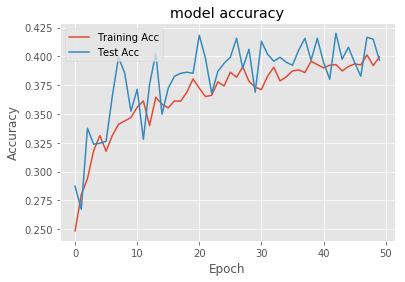

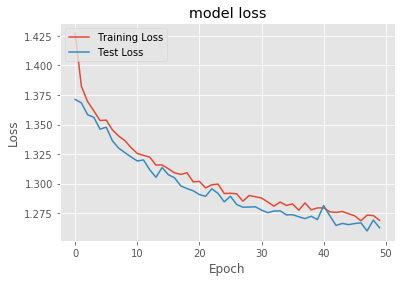

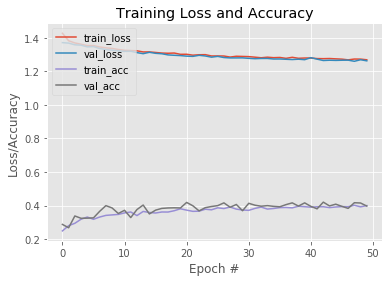

In [31]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [32]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

1152/1152 [==============================] - 1s 1ms/step
Validation Accuracy: 39.6701%
Validation Loss: 1.2626235522329807


In [33]:
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [36]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.3716517857142857


Confusion Matrix
[[  3 153 157 135]
 [  0  76 305  67]
 [  8  74 323  43]
 [  4 120  60 264]]


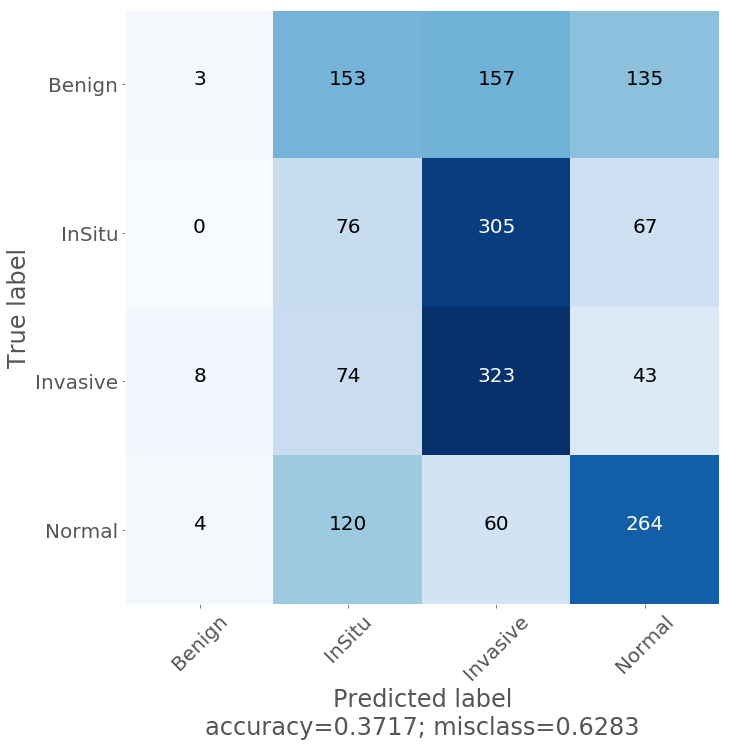

In [37]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')